In [2]:
import pandas as pd
import numpy as np
import os,cv2
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras import Input
from keras.initializers import *

In [3]:
datasets = ['./dataSets/train','./dataSets/test']

output = []

class_names = ['normal','upnormal']

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'normal': 0, 'upnormal': 1}

In [4]:
from tqdm import tqdm

def load_data():
    for dataset in datasets:
        print("Loading {}".format(dataset))

        images,labels = [],[]

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
            
                img_path = os.path.join(os.path.join(dataset,folder),file)
    #             print(img_path)
                img = cv2.imread(img_path,cv2.IMREAD_COLOR)
                img = cv2.resize(img,(150,150))

                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)

        output.append((images,labels))
        pass

    return output
    pass

In [5]:
(train_images,train_labels),(test_images,test_labels) = load_data()

Loading ./dataSets/train


100%|██████████| 4805/4805 [00:51<00:00, 92.82it/s] 


Loading ./dataSets/test


100%|██████████| 390/390 [00:02<00:00, 155.47it/s]


In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

_, train_count = np.unique(train_labels, return_counts=True)
_, test_count = np.unique(test_labels, return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Index']=['normal','upnormal']
df.columns = ['Train','Test','Name']
df

,Train,Test,Name
0,1341,234,normal
1,4805,390,upnormal


<AxesSubplot:xlabel='Name'>

<Figure size 432x288 with 0 Axes>

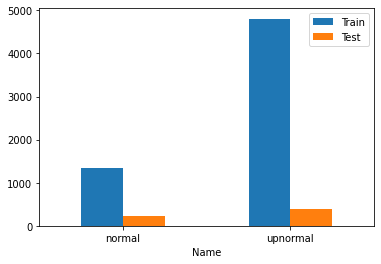

In [7]:
plt.figure()
df.set_index('Name').plot.bar(rot=0)

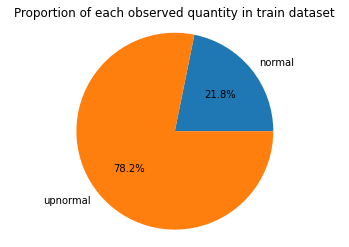

In [8]:
plt.pie(train_count,
       explode=(0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed quantity in train dataset')
plt.show()

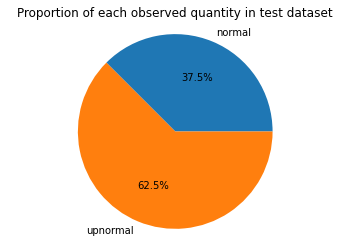

In [9]:
plt.pie(test_count,
       explode=(0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed quantity in test dataset')
plt.show()

In [10]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Test loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Test Accuracy')
    
#     ax.set_ylim(20)
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')

In [11]:
train_dir = './dataSets/train'
test_dir = './dataSets/test'
batch_size = 128

IGD = ImageDataGenerator(rescale=1./255)
train_generator = IGD.flow_from_directory(train_dir,
                                         target_size=(150,150),
                                         color_mode='rgb',
                                         batch_size=batch_size,
                                         class_mode='categorical',
                                         shuffle=True,
                                         seed = 42)
test_generator = IGD.flow_from_directory(test_dir,
                                        target_size=(150,150),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed = 42)

Found 6146 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
nb_classes = len(train_generator.class_indices)
nb_classes

2

In [13]:
def identity_block(X,f,filters,stage,block):
    
    conv_name_base = 'res_'+str(stage)+block+'_branch'
    bn_name_base = 'bn_'+str(stage)+block+'_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    # First Component of Main Path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(1,1),
               padding='same',name=conv_name_base+'2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # Second Component of Main Path
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),
              padding='same',name=conv_name_base+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # Third Component of Main Path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_name_base+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2c')(X)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    pass

In [14]:
def convolutional_block(X,f,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(s,s),
              padding='same',name=conv_base_name+'2a',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    # Second Component of main path
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),
              padding='same',name=conv_base_name+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2b')(X)
    X = Activation('relu')(X)
    
    # Third Component of main path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_base_name+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2c')(X)
    
    # Shortcut path
    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),
                       padding='same',name=conv_base_name+'1',
                       kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_base_name+'1')(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    pass

In [15]:
def ResNet(input_shape,classes):
    
    X_input = Input(input_shape)
    
    # Zero Padding
    X = ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    X = Dropout(0.25)(X)
    
    # Stage 2
    X = convolutional_block(X,f=3,filters=[64,64,128],stage=2,block='A',s=1)
    X = identity_block(X,3,[64,64,128],stage=2,block='B')
    X = identity_block(X,3,[64,64,128],stage=2,block='C')
    X = Dropout(0.25)(X)
    
    # Stage 3
    X = convolutional_block(X,f=3,filters=[128,128,256],stage=3,block='A',s=2)
    X = identity_block(X,f=3,filters=[128,128,256],stage=3,block='B')
    X = identity_block(X,f=3,filters=[128,128,256],stage=3,block='C')
    X = identity_block(X,f=3,filters=[128,128,256],stage=3,block='D')
    X = Dropout(0.25)(X)
    
    # Stage 4
    X = convolutional_block(X,f=3,filters=[256,256,512],stage=4,block='A',s=2)
    X = identity_block(X,f=3,filters=[256,256,512],stage=4,block='B')
    X = identity_block(X,f=3,filters=[256,256,512],stage=4,block='C')
    X = identity_block(X,f=3,filters=[256,256,512],stage=4,block='D')
    X = identity_block(X,f=3,filters=[256,256,512],stage=4,block='E')
    X = identity_block(X,f=3,filters=[256,256,512],stage=4,block='F')
    X = Dropout(0.25)(X)
    
    # Stage 5
    X = convolutional_block(X,f=3,filters=[512,512,1024],stage=5,block='A',s=1)
    X = identity_block(X,f=3,filters=[512,512,1024],stage=5,block='B')
    X = identity_block(X,f=3,filters=[512,512,1024],stage=5,block='C')
    X = Dropout(0.25)(X)
    
    # Stage 6
    X = convolutional_block(X,f=3,filters=[1024,1024,2048],stage=6,block='A',s=2)
    X = identity_block(X,f=3,filters=[1024,1024,2048],stage=6,block='B')
    X = identity_block(X,f=3,filters=[1024,1024,2048],stage=6,block='C')
    X = identity_block(X,f=3,filters=[1024,1024,2048],stage=6,block='D')
    X = Dropout(0.25)(X)
    
    # Average Pool Layer
    X = AveragePooling2D((2,2),name="avg_pool")(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input,outputs=X,name='ResNet')
    
    return model
    pass

In [22]:
model = ResNet(input_shape=(150,150,3),classes=nb_classes)

In [27]:
from keras.utils import model_to_dot
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [28]:
opt = SGD(lr=0.01,momentum=0.7)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [29]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                              save_best_only=True,mode='max')
callbacks_list=[checkpoint]

In [31]:
epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = train_generator.n//batch_size,
                              epochs = epochs,
                              validation_data = test_generator,
                              validation_steps = test_generator.n//batch_size,
                              callbacks = callbacks_list,
                              verbose = 1)

C:\Users\user\AppData\Local\Temp\ipykernel_24984\861756915.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 1.5758 - accuracy: 0.7818  
Epoch 1: val_accuracy did not improve from 0.62695
48/48 [==============================] - 3038s 63s/step - loss: 1.5758 - accuracy: 0.7818 - val_loss: 2212524.5000 - val_accuracy: 0.6250
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.8333  
Epoch 2: val_accuracy did not improve from 0.62695
48/48 [==============================] - 3041s 63s/step - loss: 0.4979 - accuracy: 0.8333 - val_loss: 495.3759 - val_accuracy: 0.6133
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.8900  
Epoch 3: val_accuracy improved from 0.62695 to 0.64062, saving model to model_weights.h5
48/48 [==============================] - 3050s 65s/step - loss: 0.2826 - accuracy: 0.8900 - val_loss: 4.2675 - val_accuracy: 0.6406
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.8156  
Epoch 4: val_accuracy

In [32]:
opt = SGD(lr=0.01,momentum=0.7)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                              save_best_only=True,mode='max')
callbacks_list=[checkpoint]

In [34]:
test_evaluate = model.evaluate_generator(test_generator)
print("Loss: {} Accuracy: {}".format(test_evaluate[0], test_evaluate[1]*100))

C:\Users\user\AppData\Local\Temp\ipykernel_24984\1920723365.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_evaluate = model.evaluate_generator(test_generator)


Loss: 0.9524554014205933 Accuracy: 67.14743375778198


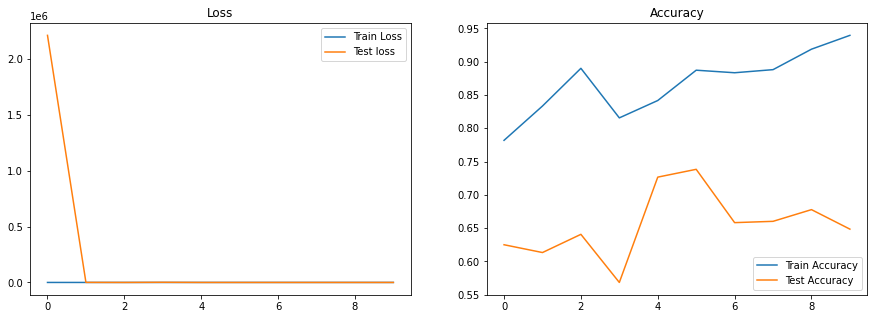

In [35]:
show_final_history(history)

C:\Users\user\AppData\Local\Temp\ipykernel_24984\100042503.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_pred = model.predict_generator(generator=test_generator)


<Figure size 432x288 with 0 Axes>

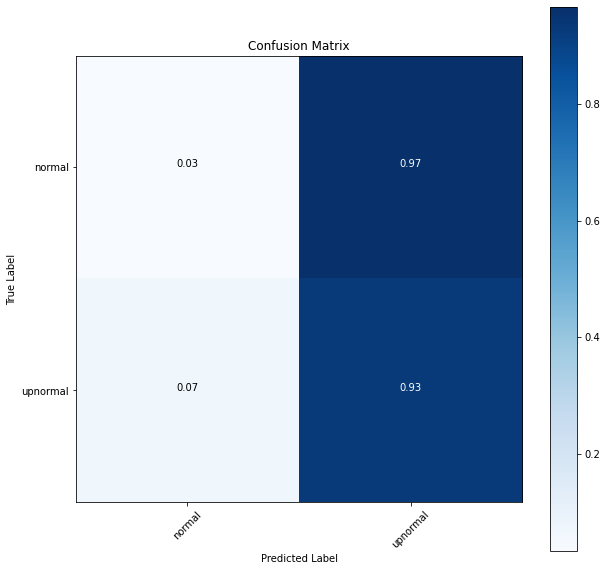

In [36]:
from sklearn.metrics import confusion_matrix
import itertools

test_pred = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

In [38]:
pred_dir = './dataSets/val'

pred_generator = IGD.flow_from_directory(pred_dir,
                                         target_size=(150,150),
                                         color_mode='rgb',
                                         batch_size=batch_size,
                                         class_mode=None,
                                         shuffle=False)

Found 16 images belonging to 1 classes.


In [39]:
pred_generator.reset()
pred_result = model.predict_generator(pred_generator,verbose=1,steps=len(pred_generator))

C:\Users\user\AppData\Local\Temp\ipykernel_24984\4183861410.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_result = model.predict_generator(pred_generator,verbose=1,steps=len(pred_generator))


1/1 [==============================] - 2s 2s/step


In [40]:
predicted_class = np.argmax(pred_result,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_class = [labels[k] for k in predicted_class]

filenames = pred_generator.filenames
# actual_class = test_generator_1.classes
results = pd.DataFrame({"Filename":filenames,
                        "Predictions":pred_class})
results.head()

,Filename,Predictions
0,pred\NORMAL2-IM-1427-0001.jpeg,upnormal
1,pred\NORMAL2-IM-1430-0001.jpeg,upnormal
2,pred\NORMAL2-IM-1431-0001.jpeg,normal
3,pred\NORMAL2-IM-1436-0001.jpeg,upnormal
4,pred\NORMAL2-IM-1437-0001.jpeg,upnormal


<Figure size 432x288 with 0 Axes>

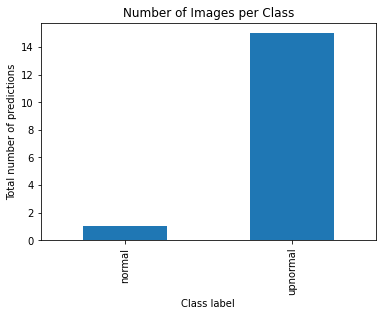

In [41]:
results_class = results.groupby('Predictions').count()

plt.figure()
results_visualisation = results_class.plot(kind='bar')
results_visualisation.legend_.remove()

plt.title("Number of Images per Class")
plt.xlabel("Class label")
plt.ylabel("Total number of predictions");

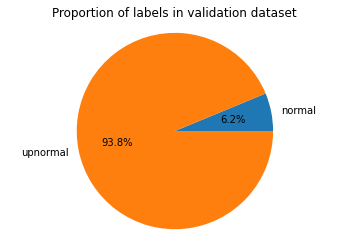

In [43]:
_,pred_count = np.unique(predicted_class,return_counts=True)

plt.pie(pred_count,
       explode=(0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of labels in validation dataset')
plt.show()

11
./dataSets/val/pred\person1949_bacteria_4880.jpeg


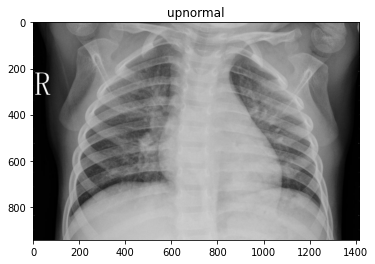

14
./dataSets/val/pred\person1952_bacteria_4883.jpeg


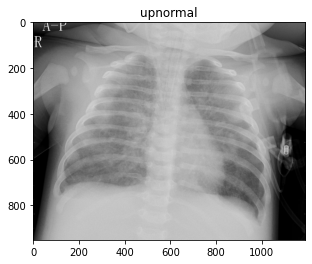

14
./dataSets/val/pred\person1952_bacteria_4883.jpeg


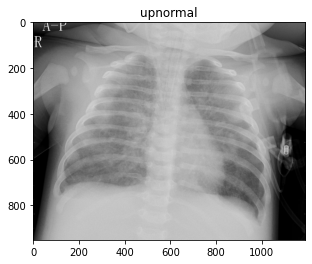

1
./dataSets/val/pred\NORMAL2-IM-1430-0001.jpeg


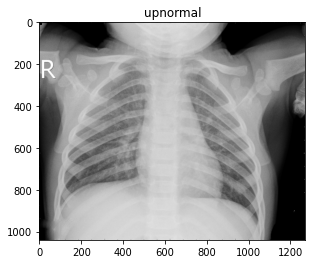

10
./dataSets/val/pred\person1947_bacteria_4876.jpeg


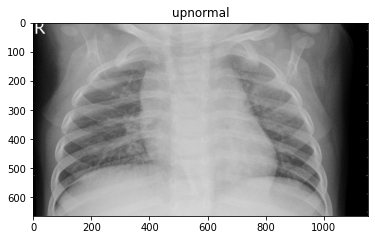

0
./dataSets/val/pred\NORMAL2-IM-1427-0001.jpeg


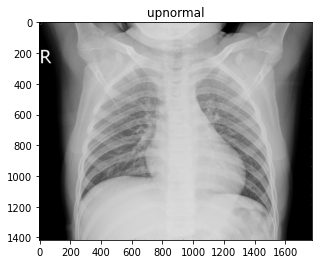

11
./dataSets/val/pred\person1949_bacteria_4880.jpeg


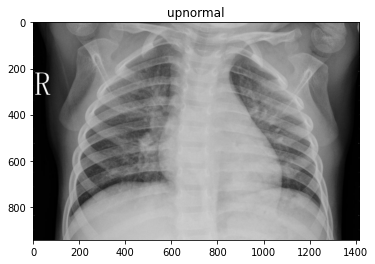

5
./dataSets/val/pred\NORMAL2-IM-1438-0001.jpeg


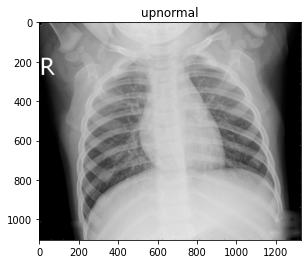

2
./dataSets/val/pred\NORMAL2-IM-1431-0001.jpeg


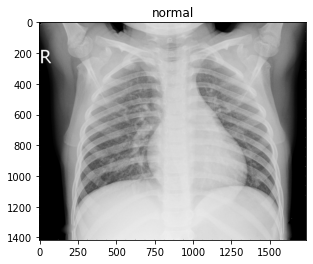

5
./dataSets/val/pred\NORMAL2-IM-1438-0001.jpeg


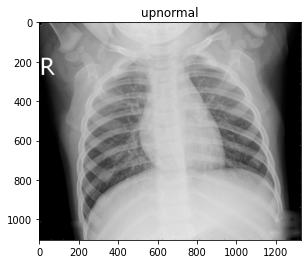

In [54]:
from random import randint

base_path = './dataSets/val/'
l = len(os.listdir(base_path+'pred/'))
# print(l)
for i in range(10):
    
    rnd_number = randint(0,l-1)
    print(rnd_number)
    filename,pred_class = results.loc[rnd_number]
    img_path = os.path.join(base_path,filename)
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(pred_class)
    plt.show()
    pass

In [55]:
test_generator_1 = IGD.flow_from_directory(test_dir,
                                          target_size=(150,150),
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 624 images belonging to 2 classes.


In [56]:
test_generator_1.reset()
test_result = model.predict_generator(test_generator_1,verbose=1,steps=len(test_generator))

C:\Users\user\AppData\Local\Temp\ipykernel_24984\2833045957.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_result = model.predict_generator(test_generator_1,verbose=1,steps=len(test_generator))


5/5 [==============================] - 40s 8s/step


In [57]:
test_class = np.argmax(test_result,axis=1)

test_class = [labels[k] for k in test_class]

filenames = test_generator_1.filenames
actual_class = [labels[h] for h in test_generator_1.classes]
test_results = pd.DataFrame({"Filename":filenames,
                        "Predictions":test_class,
                        "Actual Values":actual_class})
test_results.head()

,Filename,Predictions,Actual Values
0,normal\IM-0001-0001.jpeg,upnormal,normal
1,normal\IM-0003-0001.jpeg,upnormal,normal
2,normal\IM-0005-0001.jpeg,upnormal,normal
3,normal\IM-0006-0001.jpeg,upnormal,normal
4,normal\IM-0007-0001.jpeg,upnormal,normal


Text(0, 0.5, 'Total number of predictions')

<Figure size 432x288 with 0 Axes>

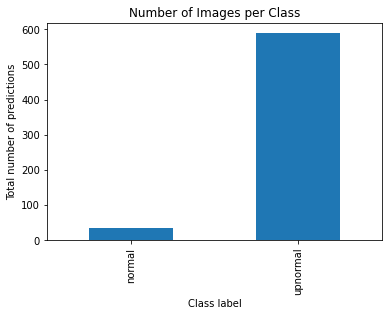

In [58]:
test_class_pred = test_results["Filename"].groupby(test_results["Predictions"]).count()

plt.figure()
plt.figure()
test_results_visualisation = test_class_pred.plot(kind='bar')
# test_results_visualisation.legend_.remove()

plt.title("Number of Images per Class")
plt.xlabel("Class label")
plt.ylabel("Total number of predictions")

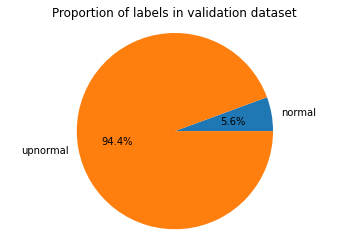

In [60]:
_,train_count = np.unique(test_class,return_counts=True)

plt.pie(train_count,
       explode=(0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of labels in validation dataset')
plt.show()

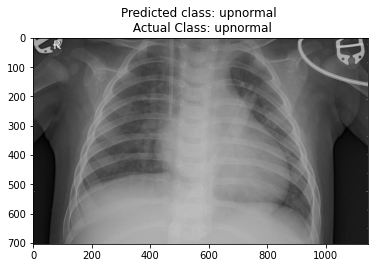

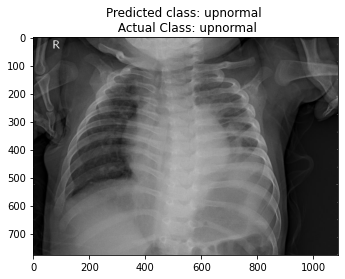

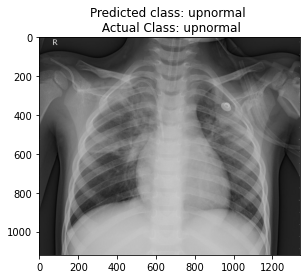

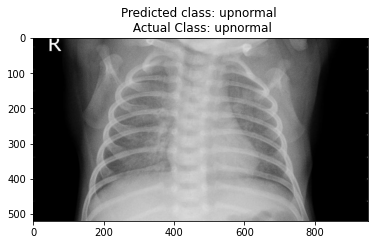

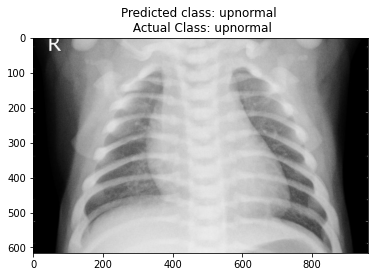

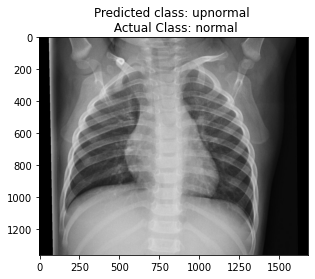

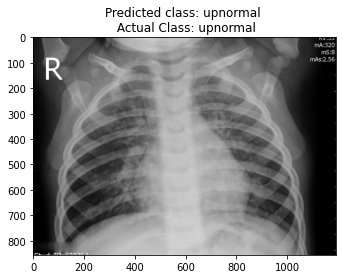

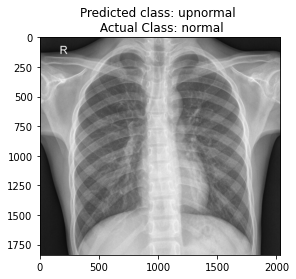

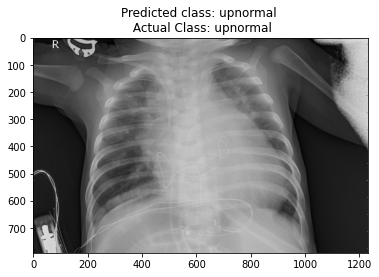

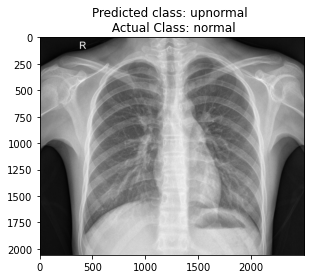

In [61]:
l = len(filenames)

for i in range(10):
    
    rnd_number = randint(0,l-1)
#     print(rnd_number)
    filename,pred_class,actual_class = test_results.loc[rnd_number]
    img_path = os.path.join(test_dir,filename)
#     print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
#     break
    pass